In [ ]:
### Import all dependencies ###

import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import numpy as np
import pandas as pd

In [ ]:
import scanpy as sc
import pandas as pd
from scipy.io import mmread

# Define the file paths
barcodes_path = "directory/file_barcodes.tsv.gz"
features_path = "directory/file_features.tsv.gz"
matrix_path = "directory/file_matrix.mtx.gz"

# Load the data
barcodes = pd.read_csv(barcodes_path, header=None, sep='\t')[0]
features = pd.read_csv(features_path, header=None, sep='\t')[0]
matrix = mmread(matrix_path).T.tocsc()

# Create the AnnData object
adata = sc.AnnData(X=matrix,
                   obs=pd.DataFrame(index=barcodes),
                   var=pd.DataFrame(index=features))

# Now `adata` is ready for further analysis

In [ ]:
# Add labels to cell_ids
adata.obs.index = [name + '-label' for name in adata.obs_names]

In [4]:
# Load cleaned cell_ids
cell_ids = pd.read_csv('directory/Labels.csv')
filtered_ids = cell_ids[(cell_ids['batch'] == 'mrd1Dx')]

In [ ]:
# Only keep common cell and gene IDs
common_ATLAS = adata.obs.index.isin(filtered_ids['Unnamed: 0'])
adata = adata[common_ATLAS]
adata

In [ ]:
# Load file with gene names
adataPB2 = muon.read_10x_h5("directory/reference_matrix.h5")
adataPB2.var_names_make_unique()
adataPB2.var

In [ ]:
import scanpy as sc

# Create a dictionary mapping gene_ids to gene_names from adataPB2
gene_id_to_name = dict(zip(adataPB2.var['gene_ids'], adataPB2.var_names))

# Save the old gene_ids in a new column "gene_ids"
adata.var["gene_ids"] = adata.var_names

# Replace the gene_ids in adata with the corresponding gene_names
adata.var_names = [gene_id_to_name[id] if id in gene_id_to_name else id for id in adata.var_names]

In [ ]:
adata.var_names

In [11]:
# Extracting RNA data only

rna_adata = adata

In [ ]:
# Top ranking expressed gene

sc.pl.highest_expr_genes(rna_adata, n_top=20, )

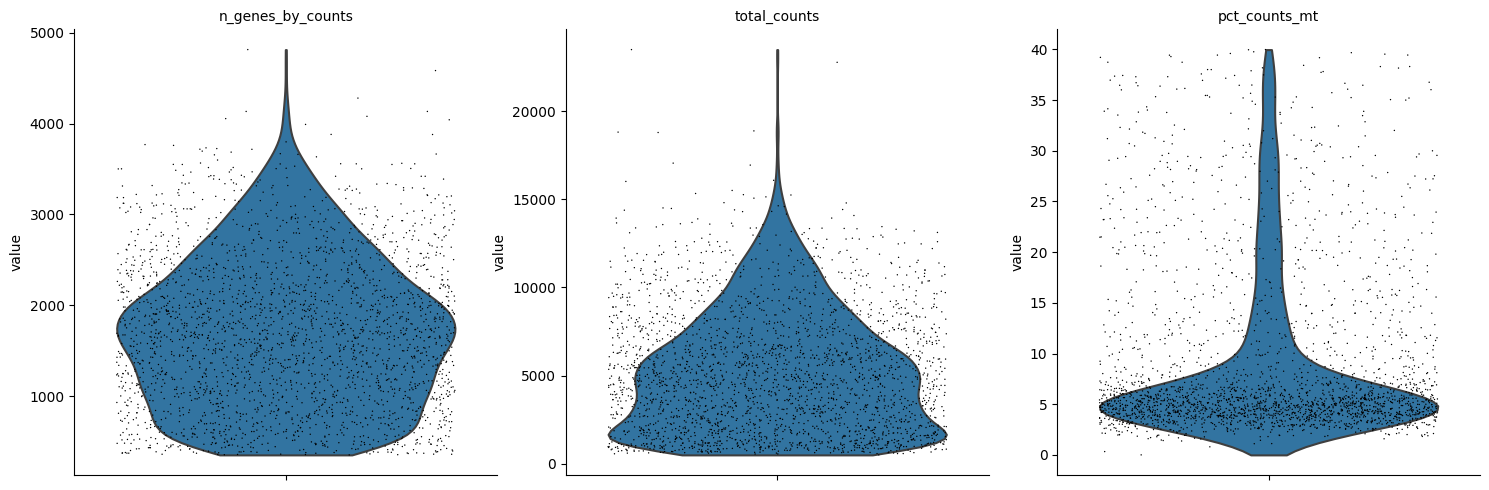

AnnData object with n_obs × n_vars = 2568 × 33538
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [13]:
# Three plot summary BEFORE filtering

rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

rna_adata.var.index = rna_adata.var.index.astype(str)
rna_adata.var_names_make_unique()

sc.pl.violin(rna_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

rna_adata

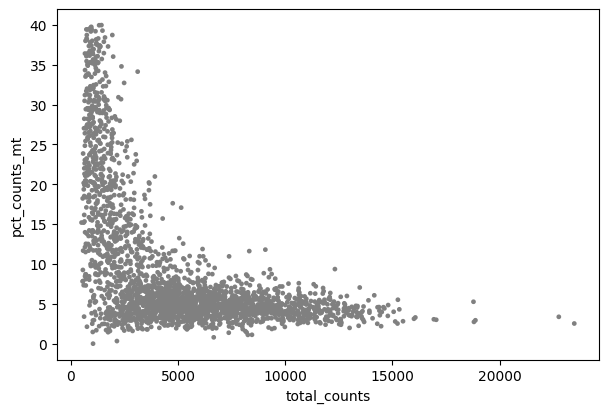

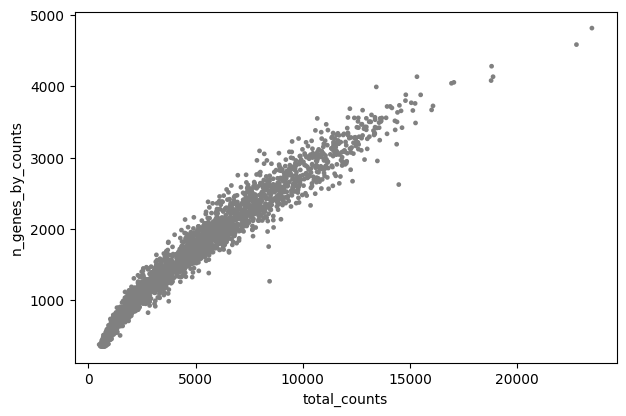

In [14]:
# Summary of genes and counts BEFORE filtering

sc.pl.scatter(rna_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(rna_adata, x='total_counts', y='n_genes_by_counts')

In [15]:
rna_adata.var

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,False,1,0.000389,99.961059,1.0
FAM138A,ENSG00000237613,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,False,0,0.000000,100.000000,0.0
AL627309.3,ENSG00000239945,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,False,9,0.003505,99.649533,9.0
AC233755.1,ENSG00000275063,False,40,0.015966,98.442368,41.0
AC240274.1,ENSG00000271254,False,29,0.011682,98.870717,30.0
AC213203.2,ENSG00000277475,False,0,0.000000,100.000000,0.0


In [16]:
# Process to filter

sc.pp.filter_cells(rna_adata, min_genes=200)
sc.pp.filter_genes(rna_adata, min_cells=3)
rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts < 5000, :]
rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts > 350, :]
rna_adata = rna_adata[rna_adata.obs.pct_counts_mt < 40, :]

In [17]:
rna_adata

View of AnnData object with n_obs × n_vars = 2568 × 14133
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

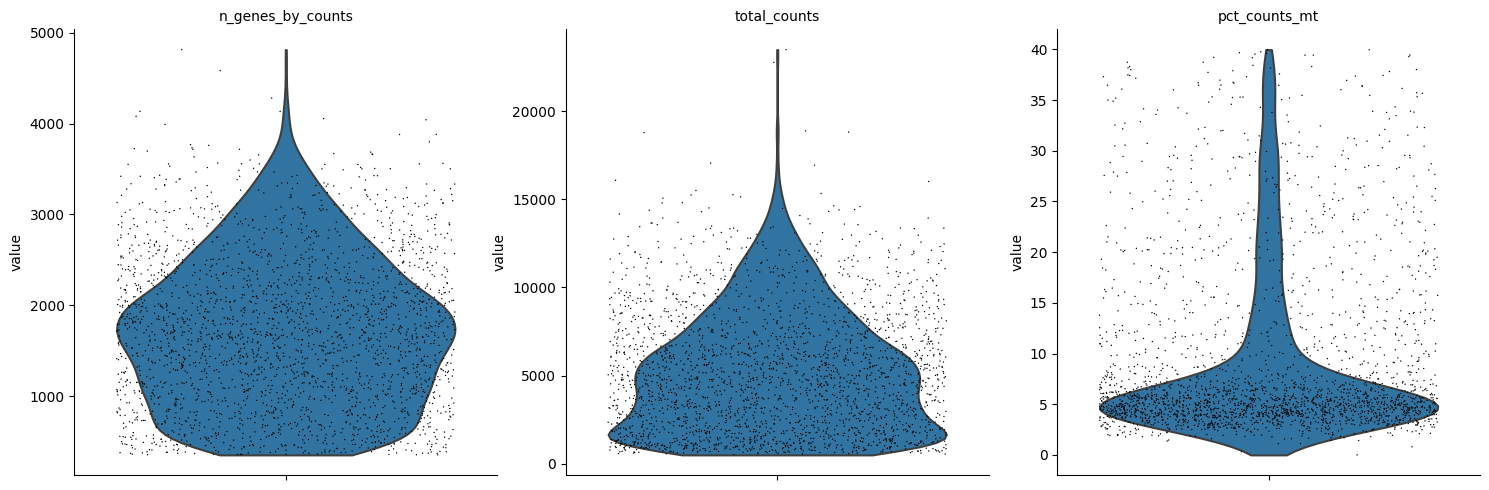

View of AnnData object with n_obs × n_vars = 2568 × 14133
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [18]:
# Three plot summary AFTER filtering

sc.pl.violin(rna_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

rna_adata

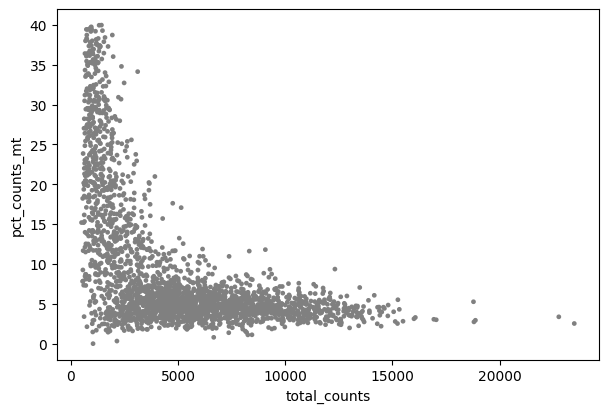

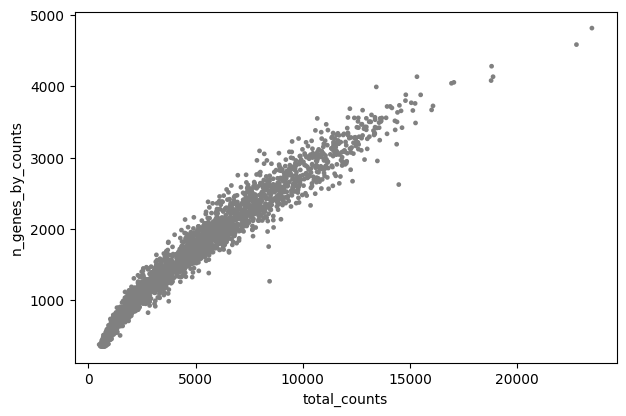

In [19]:
# Summary of genes and counts AFTER filtering

sc.pl.scatter(rna_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(rna_adata, x='total_counts', y='n_genes_by_counts')

In [20]:
rna_adata.var

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
LINC01409,ENSG00000237491,False,48,0.018692,98.130841,48.0,48
LINC00115,ENSG00000225880,False,59,0.024533,97.702492,63.0,59
NOC2L,ENSG00000188976,False,697,0.346184,72.858255,889.0,697
KLHL17,ENSG00000187961,False,33,0.012850,98.714953,33.0,33
AL645608.7,ENSG00000272512,False,129,0.064642,94.976636,166.0,129
...,...,...,...,...,...,...,...
AC011043.1,ENSG00000276256,False,11,0.004673,99.571651,12.0,11
AL592183.1,ENSG00000273748,False,27,0.010514,98.948598,27.0,27
AC233755.2,ENSG00000277856,False,9,0.003505,99.649533,9.0,9
AC233755.1,ENSG00000275063,False,40,0.015966,98.442368,41.0,40


In [ ]:
import pandas as pd

# Load the TF gene_ids from the csv
df = pd.read_excel('directory/transcriptionfactor_labels.xlsx')

# List of gene_ids from the csv
ensembl_ids = df['Ensembl ID'].dropna().tolist()

#no_ensembl_ids = df['No Ensembl ID'].dropna().tolist()

# Filter the AnnData object
rna_adata = rna_adata[:, rna_adata.var['gene_ids'].isin(ensembl_ids)]

adata=rna_adata

In [22]:
adata.var

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
HES4,ENSG00000188290,False,2049,5.490265,20.210280,14099.0,2049
TNFRSF4,ENSG00000186827,False,7,0.002726,99.727414,7.0,7
DVL1,ENSG00000107404,False,40,0.015576,98.442368,40.0,40
SKI,ENSG00000157933,False,48,0.018692,98.130841,48.0,48
ZBTB48,ENSG00000204859,False,134,0.053738,94.781931,138.0,134
...,...,...,...,...,...,...,...
U2AF1,ENSG00000160201,False,483,0.222352,81.191589,571.0,483
SIK1,ENSG00000142178,False,46,0.018692,98.208723,48.0,46
ITGB2,ENSG00000160255,False,808,0.434969,68.535826,1117.0,808
PCBP3,ENSG00000183570,False,1211,0.903037,52.842679,2319.0,1211


In [ ]:
adata.obs['n_genes_by_counts']

In [ ]:
# Add metrics to AnnData object

sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
adata.obs['n_genes_by_counts']

In [26]:
# Normalization

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [27]:
# Select high variable genes (n=4000)

#sc.pp.highly_variable_genes(adata, n_top_genes=4000, subset=True, layer="counts", flavor="seurat_v3",)

In [ ]:
# Setup scVI model

scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

model = scvi.model.SCVI(adata)

In [30]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [31]:
# Train the model (Epochs=400)
#model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 400/400: 100%|██████████| 400/400 [02:13<00:00,  3.05it/s, loss=729, v_num=1] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:13<00:00,  3.00it/s, loss=729, v_num=1]


In [32]:
#model.save('directory/MRDT1-Dx', overwrite=True)

In [ ]:
model = scvi.model.SCVI.load('directory/MRDT1-Dx', adata=adata)

In [34]:
# Create the latent scVI key
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(2568, 10)

In [35]:
# Compute clusters and visualize the latent space

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution= 0.5 ,key_added="leiden_scVI")
sc.tl.draw_graph(adata, layout='fa')

/home/brandlab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


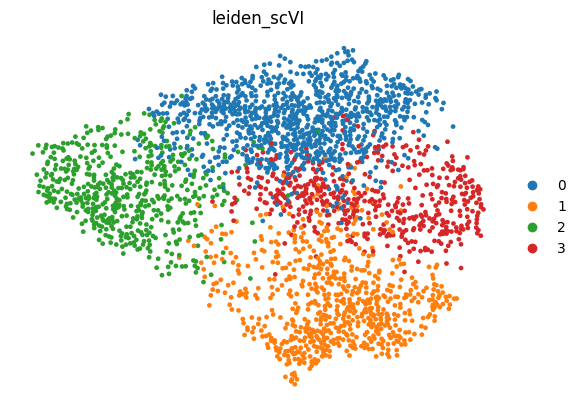

In [36]:
# Plot the FA leiden_totalVI clusters

muon.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color=["leiden_scVI"],
    frameon=False,
    ncols=1,
)

In [37]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,_scvi_batch,_scvi_labels,leiden_scVI
AAACCTGCACTCGACG-1-mrd1Dx,242,551.0,0.0,0.0,1738,0,0,0
AAACCTGCAGACACTT-1-mrd1Dx,358,834.0,0.0,0.0,2558,0,0,0
AAACCTGGTTGAGGTG-1-mrd1Dx,286,523.0,0.0,0.0,1744,0,0,3
AAACCTGTCAAGGTAA-1-mrd1Dx,361,732.0,0.0,0.0,2225,0,0,2
AAACCTGTCCGCATAA-1-mrd1Dx,240,459.0,0.0,0.0,1553,0,0,0
...,...,...,...,...,...,...,...,...
TTTGGTTGTGCTCTTC-1-mrd1Dx,146,242.0,0.0,0.0,869,0,0,1
TTTGTCACACCTCGTT-1-mrd1Dx,69,91.0,0.0,0.0,610,0,0,0
TTTGTCACACGCGAAA-1-mrd1Dx,337,795.0,0.0,0.0,2399,0,0,0
TTTGTCACAGGGTACA-1-mrd1Dx,308,646.0,0.0,0.0,2060,0,0,0


In [38]:
# Set index column

filtered_ids.set_index('Unnamed: 0', inplace=True)
filtered_ids

In [40]:
# Add the labels from the cleaned cell_ids
adata.obs['Labels'] = filtered_ids['majority_voting']

In [41]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,_scvi_batch,_scvi_labels,leiden_scVI,Labels
AAACCTGCACTCGACG-1-mrd1Dx,242,551.0,0.0,0.0,1738,0,0,0,Clone 2
AAACCTGCAGACACTT-1-mrd1Dx,358,834.0,0.0,0.0,2558,0,0,0,Clone 1
AAACCTGGTTGAGGTG-1-mrd1Dx,286,523.0,0.0,0.0,1744,0,0,3,Clone 2
AAACCTGTCAAGGTAA-1-mrd1Dx,361,732.0,0.0,0.0,2225,0,0,2,LIC
AAACCTGTCCGCATAA-1-mrd1Dx,240,459.0,0.0,0.0,1553,0,0,0,Clone 1
...,...,...,...,...,...,...,...,...,...
TTTGGTTGTGCTCTTC-1-mrd1Dx,146,242.0,0.0,0.0,869,0,0,1,Clone 2
TTTGTCACACCTCGTT-1-mrd1Dx,69,91.0,0.0,0.0,610,0,0,0,Clone 1
TTTGTCACACGCGAAA-1-mrd1Dx,337,795.0,0.0,0.0,2399,0,0,0,Clone 1
TTTGTCACAGGGTACA-1-mrd1Dx,308,646.0,0.0,0.0,2060,0,0,0,Clone 2


In [ ]:
# Get the unique annotations
annotations = np.unique(adata.obs["Labels"])

# Create a new color map
cmap = plt.get_cmap('tab10', len(annotations))

# Create a dictionary mapping each annotation to a color
color_dict = {k: cmap(i) for i, k in enumerate(annotations)}

# Change the color of "LIC" to red
color_dict["LIC"] = 'red'
color_dict["Clone 1"] = 'green'
color_dict["Clone 2"] = 'blue'

# Plot with the new color map
muon.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color=["Labels"],
    frameon=False,
    palette=color_dict,
    ncols=2,
)

In [52]:
import celltypist

# Run celltypist.annotate() function
predictions = celltypist.annotate(
    adata,
    model='directory/Full_Trained_Model_.pkl',
    majority_voting=True,
    over_clustering= 'leiden_scVI'
)

# Convert predictions to AnnData object
adata = predictions.to_adata()

🔬 Input data has 2568 cells and 1988 genes
🔗 Matching reference genes in the model
🧬 821 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


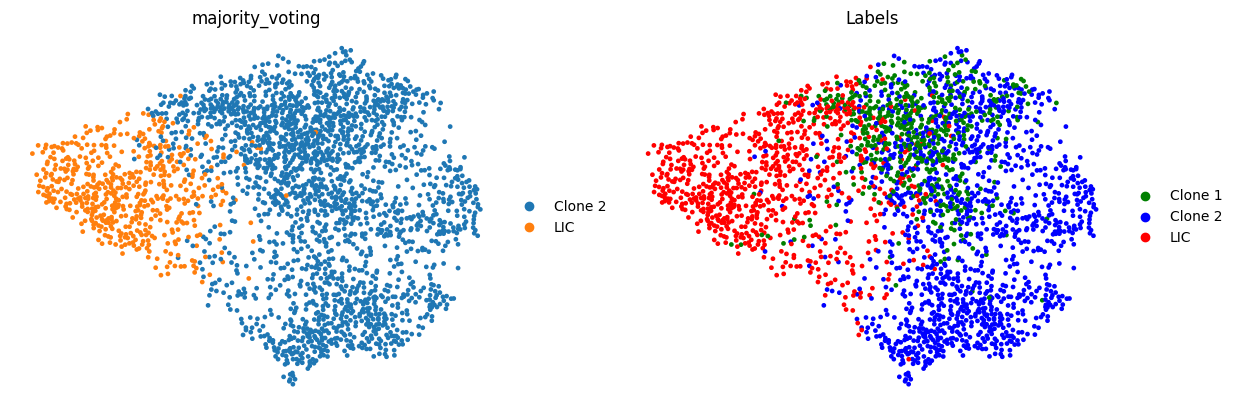

In [59]:
# Plot the FA majority_voting and Labels
muon.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color=["majority_voting","Labels"],
    frameon=False,
    ncols=2,
)

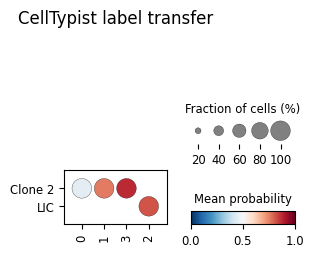

In [54]:
# Plot confidence score of leiden clusters
celltypist.dotplot(predictions, use_as_reference = 'leiden_scVI', use_as_prediction = 'majority_voting')

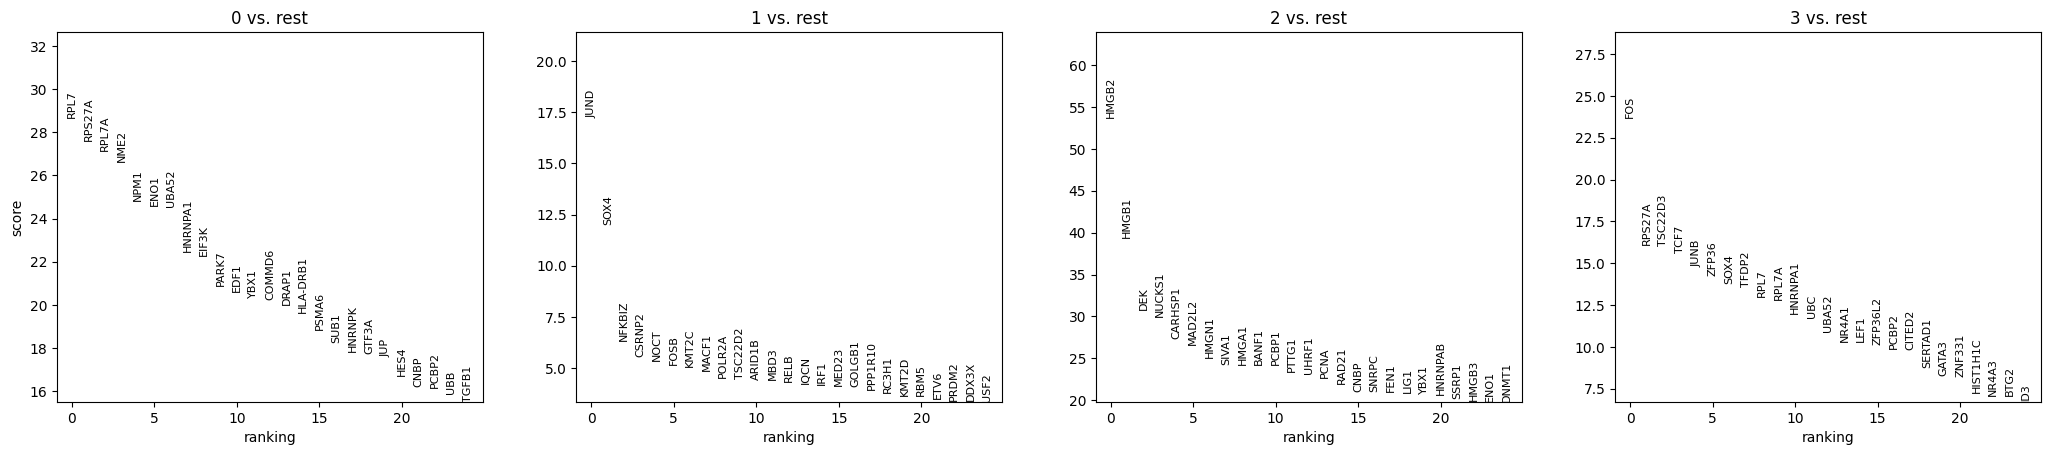

,0,1,2,3
0,RPL7,JUND,HMGB2,FOS
1,RPS27A,SOX4,HMGB1,RPS27A
2,RPL7A,NFKBIZ,DEK,TSC22D3
3,NME2,CSRNP2,NUCKS1,TCF7
4,NPM1,NOCT,CARHSP1,JUNB
5,ENO1,FOSB,MAD2L2,ZFP36
6,UBA52,KMT2C,HMGN1,SOX4
7,HNRNPA1,MACF1,SIVA1,TFDP2
8,EIF3K,POLR2A,HMGA1,RPL7
9,PARK7,TSC22D2,BANF1,RPL7A


In [55]:
# Differential Expression of genes in leiden clusters

import torch

torch.set_printoptions()  # This resets all options to their default values
sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
adata.obs

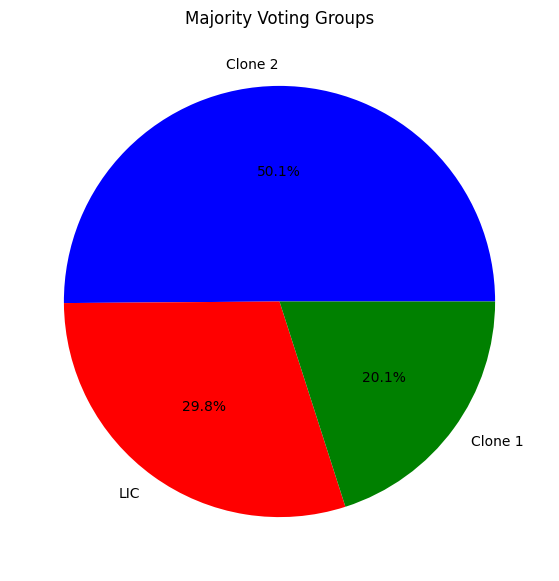

In [ ]:
# Create pie chart for visualization
import matplotlib.pyplot as plt

# Get the counts for each majority_voting group
group_counts = adata.obs['Labels'].value_counts()
group_colors = [color_dict[group] for group in group_counts.index]

# Create the pie chart
plt.figure(figsize=(10, 7))
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%',colors=group_colors)
plt.title('Majority Voting Groups')
plt.show()

In [146]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Save AnnData Object
adata.write('directory/analysis.h5ad')